In [108]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [109]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [110]:
# plot setup
plt.rcParams["figure.figsize"] = (6,4)

### Helper functions

In [111]:
def compatibility_diff(df, compatibilities=['compatible','incompatible']):
    '''
    Returns difference between compatibility conditions for response correct and rt (second minus first)
    '''
    diffs = df[df.compatibility==compatibilities[1]][['response_correct','rt']].iloc[0] - df[df.compatibility==compatibilities[0]][['response_correct','rt']].iloc[0] 
    
    
    diffs = diffs.rename({'response_correct':'diff_response_correct',
                                'rt':'diff_rt'})
    
    return diffs

# Make dataframes

In [112]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping']

# which iteration name should we use?
# iteration_name = 'pilot_1'
# iteration_name = 'post_run_0'
iteration_name = 'post_wm_prolific_pilot'
iteration_names = [iteration_name]

In [113]:
# metadata
# TODO: check this works
query = coll.find({"$and":[
                        {'datatype':'metadata'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_meta = pd.DataFrame(query)
print(len(df_meta))

16


In [114]:
# metadata
# TODO: check this works
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_all = pd.DataFrame(query)
print(len(df_all))

2390


In [115]:
# zipping trials
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
                        ]})
df_zip = pd.DataFrame(query)
print(len(df_zip))

0


In [116]:
# building trials
query = coll.find({"$and":[
                        {'trial_type':'block-construction'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_build = pd.DataFrame(query)
print(len(df_build))

0


In [117]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'block_placement'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_block_placements = pd.DataFrame(query)
print(len(df_block_placements))

1032


In [118]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'reset'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_resets = pd.DataFrame(query)
print(len(df_resets))

288


In [119]:
# working memory versions

In [120]:
# zipping trials
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping-wm'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
                        ]})
df_zip = pd.DataFrame(query)
print(len(df_zip))

760


In [121]:
# building trials
query = coll.find({"$and":[
                        {'trial_type':'block-construction-wm'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_build = pd.DataFrame(query)
print(len(df_build))

181


In [122]:
list(df_all[df_all.trial_type == 'survey-text']['response'])

[{'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'NO', 'confused': 'NO', 'comments': 'NO'},
 {'technical': 'No', 'confused': 'No', 'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'No', 'confused': '', 'comments': ''},
 {'technical': 'No', 'confused': 'No', 'comments': 'No'},
 {'technical': 'none thanks',
  'confused': 'no',
  'comments': 'It was fun thanks'},
 {'technical': 'No.',
  'confused': 'No.',
  'comments': 'No, thank you. Enjoyed it.'},
 {'technical': 'No',
  'confused': 'No, all was clear.',
  'comments': 'Thank you!'}]

### Apply exclusion criteria

In [123]:
remove_tests = False

if remove_tests:
    df_zip = df_zip[~df_zip.workerID.isna()]
    df_build = df_build[~df_build.workerID.isna()]
    df_survey = df_survey[~df_survey.workerID.isna()]

In [124]:
# remove incomplete datasets
a = df_zip.groupby('gameID').apply(len) == 76
complete_zipping_set_gameIDs = list(a[a].index)
df_zip = df_zip[df_zip.gameID.isin(complete_zipping_set_gameIDs)]
df_build = df_build[df_build.gameID.isin(complete_zipping_set_gameIDs)]

In [125]:
df_build

,_id,timeAbsolute,timeRelative,blocks,discreteWorld,eventType,endReason,trial_start_time,relative_time,stimURL,...,trial_index,time_elapsed,internal_node_id,experimentName,iterationName,workerID,gameID,studyLocation,datatype,response_key_dict
0,6335eeb07ca4957a1bce5714,1.664479e+12,88612,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664479e+12,30689,https://lax-tower-4-block-unique-silhouettes-j...,...,3,90923,0.0-3.0,block_construction_zipping,post_wm_prolific_pilot,5bfee33dce8e790001551d25,6073-12345fac-5aa6-4d22-a4d4-23464a60566e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
1,6335eec57ca4957a1bce571e,1.664479e+12,109379,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664479e+12,16157,https://lax-tower-4-block-unique-silhouettes-j...,...,4,111689,0.0-4.0,block_construction_zipping,post_wm_prolific_pilot,5bfee33dce8e790001551d25,6073-12345fac-5aa6-4d22-a4d4-23464a60566e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
2,6335eed47ca4957a1bce5729,1.664479e+12,124337,"[{'x': 3, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664479e+12,10356,https://lax-tower-4-block-unique-silhouettes-j...,...,5,126648,0.0-5.0,block_construction_zipping,post_wm_prolific_pilot,5bfee33dce8e790001551d25,6073-12345fac-5aa6-4d22-a4d4-23464a60566e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
3,6335eee47ca4957a1bce5731,1.664479e+12,173703,"[{'x': 5, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664479e+12,127174,https://lax-tower-4-block-unique-silhouettes-j...,...,3,176341,0.0-3.0,block_construction_zipping,post_wm_prolific_pilot,5cac937cd889c700010d7c65,1088-7337efdd-e85e-4963-8f13-9d1f04db2b33,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
4,6335eef47ca4957a1bce573f,1.664479e+12,189659,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664479e+12,11345,https://lax-tower-4-block-unique-silhouettes-j...,...,4,192323,0.0-4.0,block_construction_zipping,post_wm_prolific_pilot,5cac937cd889c700010d7c65,1088-7337efdd-e85e-4963-8f13-9d1f04db2b33,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,6336029e7ca4957a1bce5fde,1.664484e+12,444611,"[{'x': 6, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664484e+12,12155,https://lax-tower-4-block-unique-silhouettes-j...,...,14,447378,0.0-14.0,block_construction_zipping,post_wm_prolific_pilot,5ce9b0e4be5a6b00163f6870,8677-e6f603b4-e29b-4245-91f5-46104541bb8e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
177,633602af7ca4957a1bce5fe4,1.664484e+12,462022,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664484e+12,12571,https://lax-tower-4-block-unique-silhouettes-j...,...,15,464773,0.0-15.0,block_construction_zipping,post_wm_prolific_pilot,5ce9b0e4be5a6b00163f6870,8677-e6f603b4-e29b-4245-91f5-46104541bb8e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
178,633602be7ca4957a1bce5fea,1.664484e+12,477366,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,1.664484e+12,10492,https://lax-tower-4-block-unique-silhouettes-j...,...,16,480130,0.0-16.0,block_construction_zipping,post_wm_prolific_pilot,5ce9b0e4be5a6b00163f6870,8677-e6f603b4-e29b-4245-91f5-46104541bb8e,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
179,633602cd7ca495

In [126]:
df_zip = df_zip.merge(df_meta[['gameID','rotation_name']], on='gameID', how='left')

In [127]:
df_zip = df_zip[~pd.isna(df_zip.rotation_name)]

In [128]:
incomplete_zipping_set_gameIDs = list(a[~a].index)

In [129]:
print(str(len(incomplete_zipping_set_gameIDs)) + ' ppts removed for incomplete data')
print(str(len(complete_zipping_set_gameIDs)) + ' ppts left')

0 ppts removed for incomplete data
10 ppts left


In [130]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.5
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed for low accuracy')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')

1 ppts removed for low accuracy
9 ppts left


In [131]:
# TODO: flag button bashers
# key_presses is the number of times a key was pressed minus one.
df_zip.key_presses

0      0
1      0
2      0
3      0
4      0
      ..
679    0
680    0
681    0
682    0
683    0
Name: key_presses, Length: 684, dtype: int64

In [132]:
# flag fast RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [133]:
print('{} trials flagged for slow RT'.format(df_zip['flagRT'].sum()))

1 trials flagged for slow RT


#### remove practice trials from df_zip

In [134]:
df_zip_practice = df_zip[df_zip.practice]
df_zip = df_zip[df_zip.practice == False]

## Add useful columns

In [135]:
# construct compatible variable
'''
A trial is compatible if the parts displayed are of the same orientation (wide/tall)
as the parts of that composite that were built.
If no parts of the composite were built, the trial is 'novel'. 
'''

df_zip.loc[:,'compatibility'] = 'novel'

df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'tall')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'wide')), 'compatibility'] = 'compatible'


df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'wide')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'tall')), 'compatibility'] = 'incompatible'

In [136]:
# is response_correct as we expect
df_zip.loc[:,'expected_response'] = df_zip.apply(lambda row: row.response_key_dict[row.validity],axis=1)
df_zip.loc[:,'recalculated_response_correct'] = df_zip.expected_response == df_zip.response
assert((df_zip.recalculated_response_correct == df_zip.response_correct).all())

# Test experiment design

In [137]:
df_zip[['compatibility','part_type','validity','part_a','part_b','composite_id']]

,compatibility,part_type,validity,part_a,part_b,composite_id
8,compatible,wide,invalid,wide_015,wide_008,talls_101_114
9,incompatible,tall,invalid,tall_122,tall_114,talls_101_114
10,novel,tall,invalid,tall_111,tall_122,talls_111_127
11,compatible,tall,invalid,tall_097,tall_127,talls_111_127
13,novel,wide,invalid,wide_011,wide_024,talls_111_127
...,...,...,...,...,...,...
679,compatible,wide,valid,wide_019,wide_008,talls_101_114
680,novel,wide,invalid,wide_011,wide_022,talls_111_127
681,incompatible,wide,invalid,wide_025,wide_011,talls_102_122
682,novel,tall,invalid,tall_111,tall_126,talls_111_127


We collected some extra participants. Here we drop the extras (taking the last ones). We should ensure that dropping these particular participants doesn't change our results before reporting them.

In [138]:
# check number of ppts in each condition
df_zip_ppts = df_zip.groupby('gameID').first()
df_zip_ppts.groupby('rotation_name').count()

,index,_id,trial_start_time,trial_finish_time,rt,stimulus,response,response_correct,stimURL,practice,...,composite_talls_name,actual_tall_parts,actual_wide_parts,trial_num,block,phase,flagRT,compatibility,expected_response,recalculated_response_correct
rotation_name,,,,,,,,,,,,,,,,,,,,,
p_1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
p_2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
q_1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
q_2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
r_1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [139]:
df_zip['gameID'].nunique()

9

In [140]:
df_ppts = df_zip.groupby('gameID').first().reset_index()
extras = list(\
df_ppts[df_ppts['rotation_name'] == 'r_1']['gameID'][12:].append(\
df_ppts[df_ppts['rotation_name'] == 'r_2']['gameID'][12:]))

df_zip = df_zip[~df_zip.gameID.isin(extras)]
# df_zip.groupby('gameID').first().groupby('rotation_name').count()
print('removed {} extra participants to preserve counterbalancing.'.format(len(extras)))

removed 0 extra participants to preserve counterbalancing.


#### Double checking built chunks

In [141]:
built_chunk_array = df_build.groupby('gameID').chunk_id.unique().apply(np.sort)
built_chunk_df = built_chunk_array.reset_index()
built_chunk_df = built_chunk_df.rename(columns={'chunk_id':'built_chunks'})

In [142]:
df_build = df_build.merge(built_chunk_df, how='left', on='gameID')
df_zip = df_zip.merge(built_chunk_df, how='left', on='gameID')

In [143]:
# df_meta_built = df_meta.groupby('gameID').building_chunks.first().apply(np.sort).reset_index()
# df_zip = df_zip.merge(df_meta_built, how='left', on='gameID')

In [144]:
df_zip.built_chunks

0      [tall_102, tall_122, wide_008, wide_019]
1      [tall_111, tall_127, wide_008, wide_019]
2      [tall_102, tall_122, wide_008, wide_019]
3      [tall_111, tall_127, wide_008, wide_019]
4      [tall_102, tall_122, wide_008, wide_019]
                         ...                   
643    [tall_102, tall_122, wide_008, wide_019]
644    [tall_102, tall_122, wide_008, wide_019]
645    [tall_102, tall_122, wide_008, wide_019]
646    [tall_102, tall_122, wide_008, wide_019]
647    [tall_102, tall_122, wide_008, wide_019]
Name: built_chunks, Length: 648, dtype: object

In [145]:
# Double check that compatible actually had those parts built 

a = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].actual_tall_parts.apply(np.sort)

b = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].built_chunks.apply(lambda part_list: np.sort([part for part in part_list if 'tall' in part]))

a.equals(b)

True

### Timing data

IMPORTANT: This is specific to this post-only version of the study

In [146]:
post_start = df_zip[df_zip.trial_num == 0.0][['gameID','trial_start_time']]
post_finish = df_zip[df_zip.trial_num == 71.0][['gameID','trial_finish_time']]
post_start = post_start.rename(columns = {'trial_start_time': 'post_start_time'})
post_finish = post_finish.rename(columns = {'trial_finish_time':'post_finish_time'})

post_timing = post_start.merge(post_finish, on='gameID')
post_timing['post_duration'] = post_timing['post_finish_time'] - post_timing['post_start_time']
post_timing['post_duration_min'] = post_timing['post_duration'] / (1000 * 60)
post_timing

,gameID,post_start_time,post_finish_time,post_duration,post_duration_min
0,1088-7337efdd-e85e-4963-8f13-9d1f04db2b33,1.664479e+12,1.664480e+12,446360.0,7.439333
1,6073-12345fac-5aa6-4d22-a4d4-23464a60566e,1.664479e+12,1.664480e+12,441847.0,7.364117
2,9747-08355d97-a76c-45c9-b4d9-5ec7caeb50a1,1.664479e+12,1.664480e+12,408078.0,6.801300
3,1586-54ccfdc5-5b6e-4ea5-8f4a-a8788524d1f1,1.664480e+12,1.664480e+12,560152.0,9.335867
4,6036-980bb167-23b0-4002-8c31-56c53e8a9a64,1.664480e+12,1.664480e+12,624915.0,10.415250
5,0992-bc4b08e5-6302-4abc-a401-ea8264e616b7,1.664480e+12,1.664481e+12,597822.0,9.963700
6,5397-9ed2d07c-79f3-4a1e-97f0-846472b3c7ff,1.664480e+12,1.664481e+12,706075.0,11.767917
7,0323-9d7e76f6-0cfb-47b8-bd73-22dfad861f77,1.664481e+12,1.664482e+12,1166684.0,19.444733
8,8677-e6f603b4-e29b-4245-91f5-46104541bb8e,1.664484e+12,1.664485e+12,460500.0,7.675000


In [147]:
df_build['trial_num'] = df_build.trial_index - 3
df_build['trial_num']

build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
build_timing = build_start.merge(build_finish, on='gameID')
build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
build_timing

,gameID,build_start_time,build_finish_time,build_duration,build_duration_min
0,6073-12345fac-5aa6-4d22-a4d4-23464a60566e,1.664479e+12,1.664479e+12,304760.0,5.079333
1,1088-7337efdd-e85e-4963-8f13-9d1f04db2b33,1.664479e+12,1.664479e+12,424115.0,7.068583
2,9747-08355d97-a76c-45c9-b4d9-5ec7caeb50a1,1.664479e+12,1.664479e+12,320572.0,5.342867
3,0992-bc4b08e5-6302-4abc-a401-ea8264e616b7,1.664479e+12,1.664480e+12,737880.0,12.298000
4,1586-54ccfdc5-5b6e-4ea5-8f4a-a8788524d1f1,1.664479e+12,1.664480e+12,472549.0,7.875817
5,0685-3d7e8a06-f2ca-40b3-8f75-fe72f4f3cde1,1.664479e+12,1.664480e+12,360625.0,6.010417
6,6036-980bb167-23b0-4002-8c31-56c53e8a9a64,1.664479e+12,1.664480e+12,362686.0,6.044767
7,5397-9ed2d07c-79f3-4a1e-97f0-846472b3c7ff,1.664480e+12,1.664480e+12,418412.0,6.973533
8,0323-9d7e76f6-0cfb-47b8-bd73-22dfad861f77,1.664480e+12,1.664481e+12,1183731.0,19.728850
9,8677-e6f603b4-e29b-4245-91f5-46104541bb8e,1.664484e+12,1.664484e+12,365278.0,6.087967


#### Trying to extract time in instructions. Not saved in experiment so using timestamps. Was taking too long so moving on.

In [148]:
timings = post_timing.merge(build_timing, on='gameID')\
#                     .merge(experiment_start, how='left', on='gameID')

timings['total_duration'] = timings.post_finish_time - timings.build_start_time
timings['total_duration_min'] = timings['total_duration'] / (1000*60)

mean post duration:  10.023024074074073


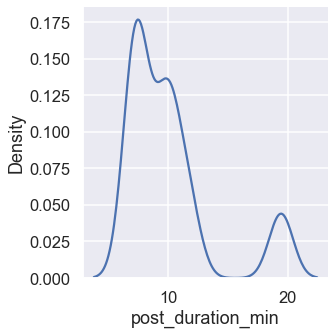

In [149]:
sns.displot(timings, x="post_duration_min", kind="kde", bw_adjust=.4)
print('mean post duration: ', timings.post_duration_min.mean())

mean building duration:  8.49996851851852


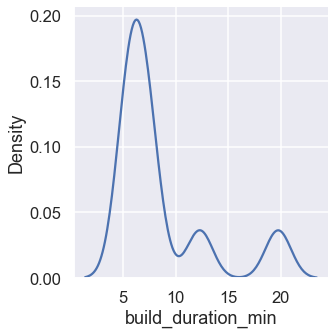

In [150]:
sns.displot(timings, x="build_duration_min", kind="kde", bw_adjust=.4)
print('mean building duration: ', timings.build_duration_min.mean())

mean total duration:  21.737540740740737


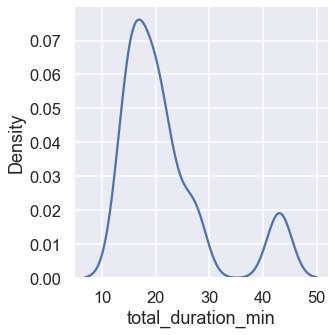

In [151]:
sns.displot(timings, x="total_duration_min", kind="kde", bw_adjust=.4)
print('mean total duration: ', timings.total_duration_min.mean())

#### export for stats

In [152]:
filename = '../results/zipping/csv/df_zip_{}.csv'.format(iteration_name)
df_zip.to_csv(filename)
print(filename)

../results/zipping/csv/df_zip_post_wm_prolific_pilot.csv


# Analysis 

### Analysis setup

In [153]:
block_order = ['pre_0', 'pre_1', 'post_0', 'post_1']
phase_order = ['pre_zipping_trials', 'post_zipping_trials']

No handles with labels found to put in legend.


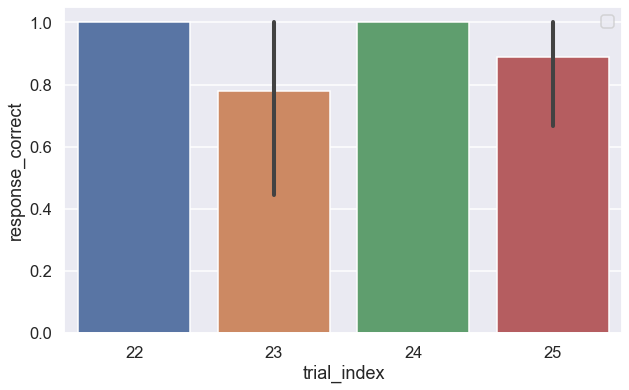

In [154]:
# Do people understand practice trials?

fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip_practice, 
              y= "response_correct", 
              x= "trial_index",
              )

plt.legend(bbox_to_anchor=(1,1))

In general yes. Lots of mistakes in the first trial. People reported being thrown off by the mask. But accuracy is v high by the end.

In [155]:
df_zip = df_zip[~df_zip.practice].reset_index(drop=True)

### plot setup

In [156]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

## zipping trials- group level performance

<AxesSubplot:xlabel='gameID', ylabel='response_correct'>

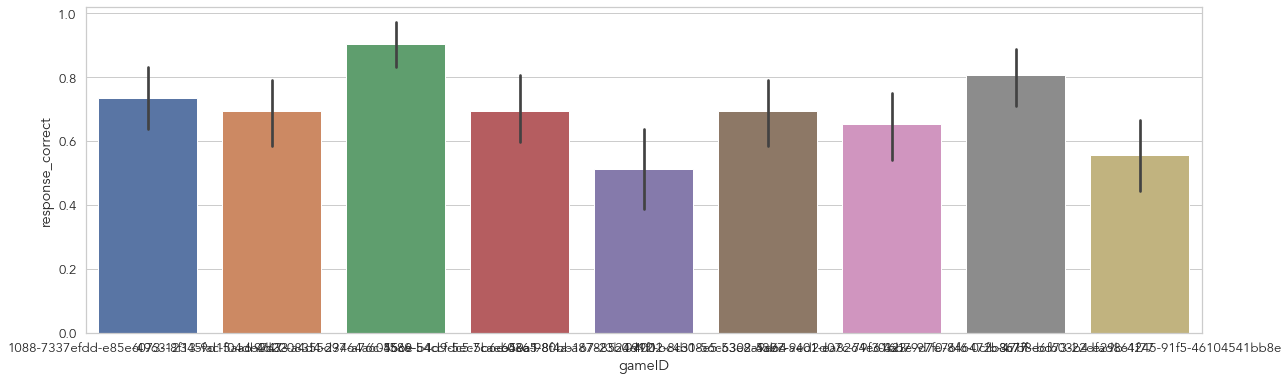

In [157]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "response_correct", 
              x= "gameID",
              )

<AxesSubplot:xlabel='gameID', ylabel='rt'>

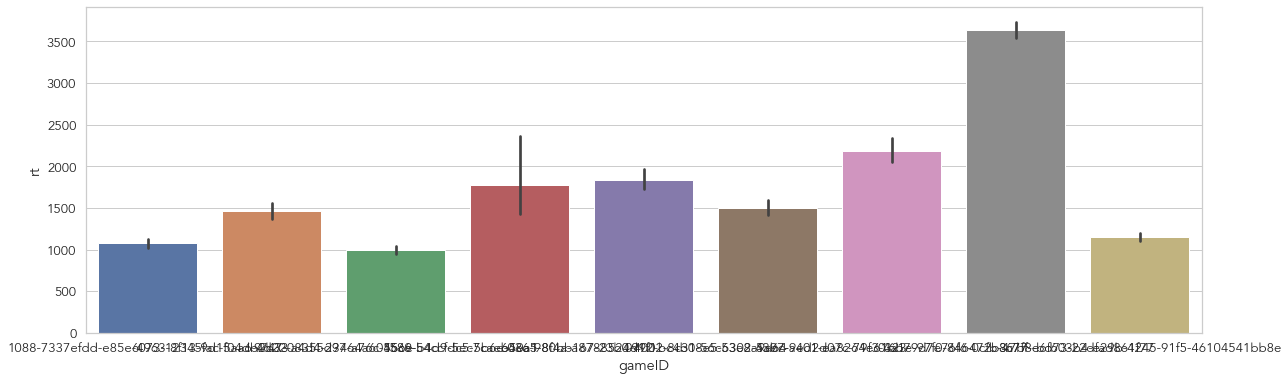

In [158]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "rt", 
              x= "gameID",
              )

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

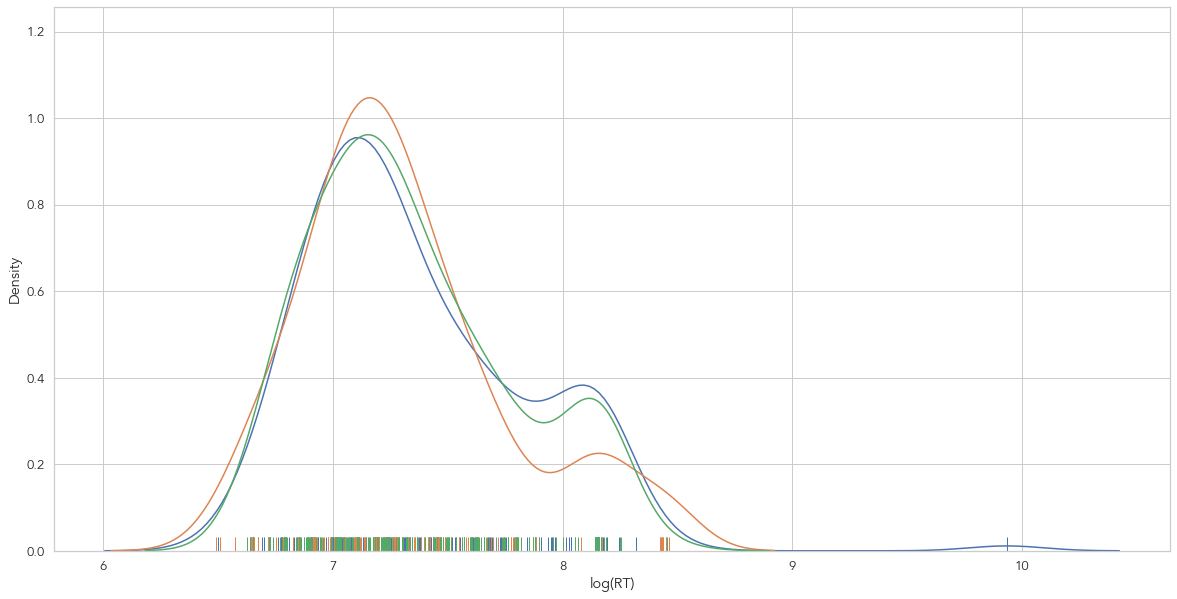

In [159]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[df_zip.compatibility == 'compatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'incompatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'novel'].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

In [160]:
df_zip['trial_bin'] = np.floor((df_zip.trial_num) / 12)

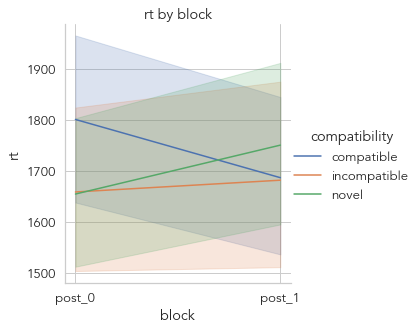

In [161]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                kind="line",
                height=4.6,
                aspect=1)
plt.title('rt by block')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

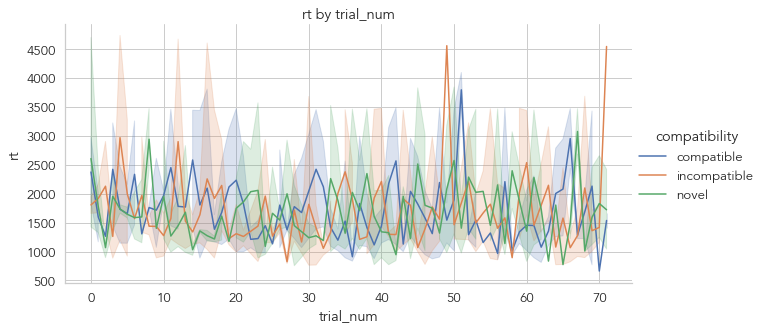

In [162]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_num",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial_num')
plt.show()

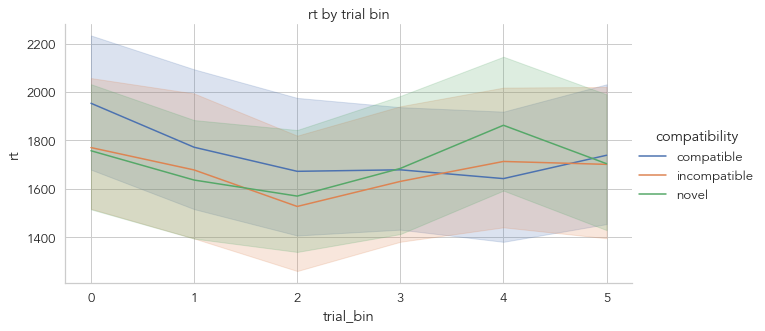

In [163]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_bin",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial bin')
plt.show()

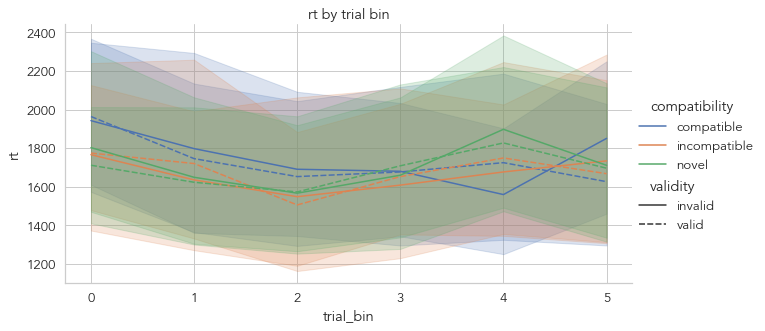

In [164]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_bin",
                hue="compatibility",
                style="validity",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial bin')
plt.show()

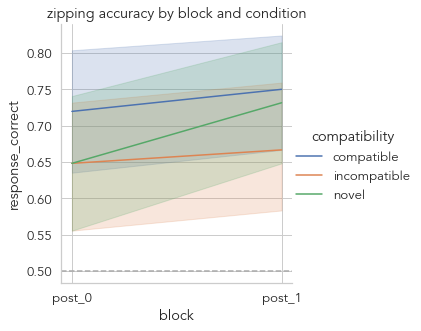

In [165]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                kind="line",
                height=4.6, 
                aspect=1) 
# plt.ylim(0,1)
plt.title('zipping accuracy by block and condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

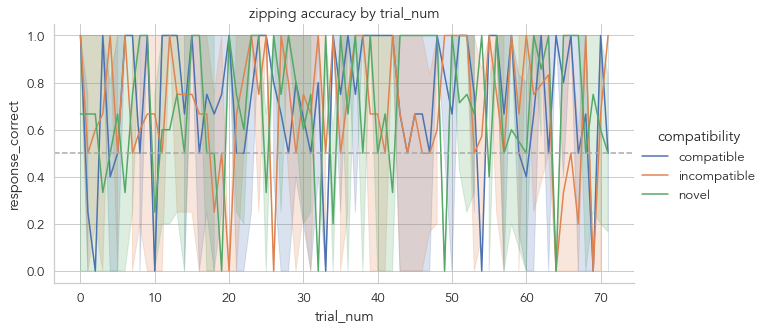

In [166]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_num",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial_num')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

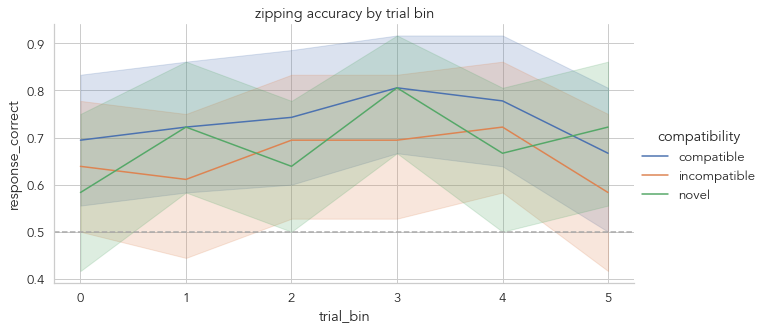

In [167]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_bin",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial bin')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

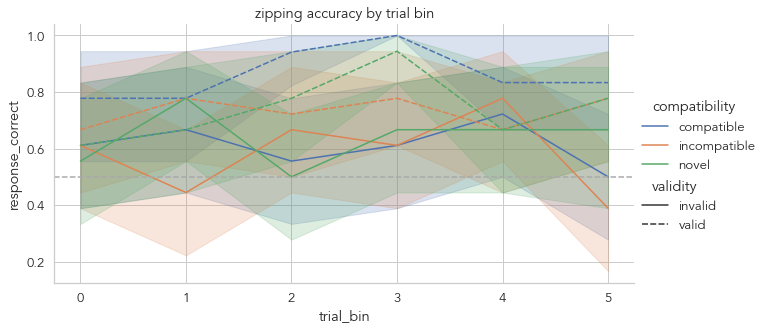

In [168]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_bin",
                hue="compatibility",
                style="validity",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial bin')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

In [90]:
df_zip.phase

0      post_zipping_trials
1      post_zipping_trials
2      post_zipping_trials
3      post_zipping_trials
4      post_zipping_trials
              ...         
643    post_zipping_trials
644    post_zipping_trials
645    post_zipping_trials
646    post_zipping_trials
647    post_zipping_trials
Name: phase, Length: 648, dtype: object

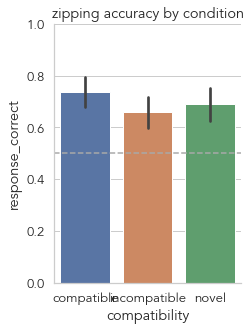

In [91]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

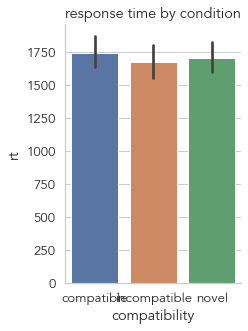

In [92]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

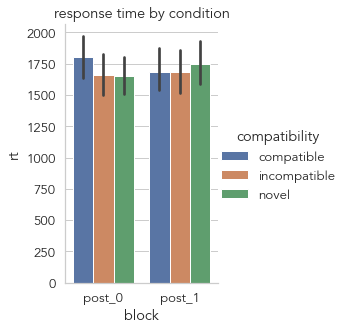

In [93]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                hue="compatibility",
                x="block",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

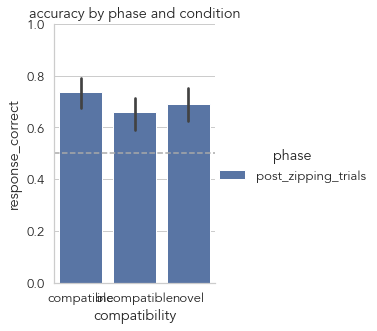

In [94]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by phase and condition')
plt.show()

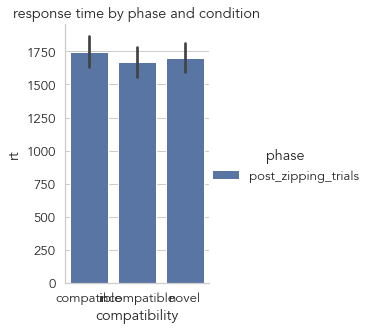

In [95]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by phase and condition')
plt.show()

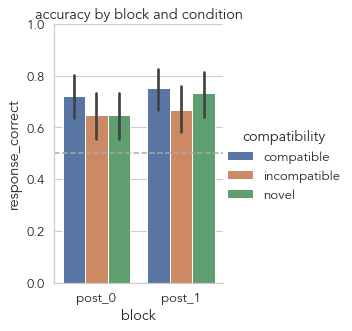

In [96]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by block and condition')
plt.show()

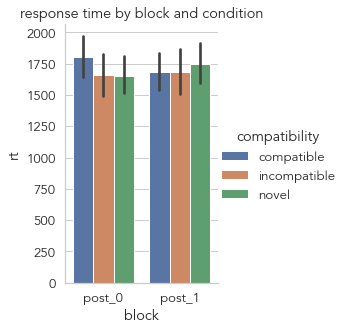

In [97]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by block and condition')
plt.show()

### Validity

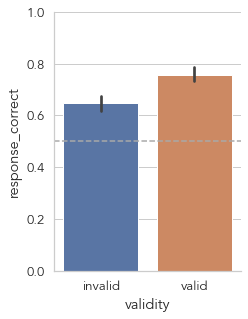

In [574]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="validity",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

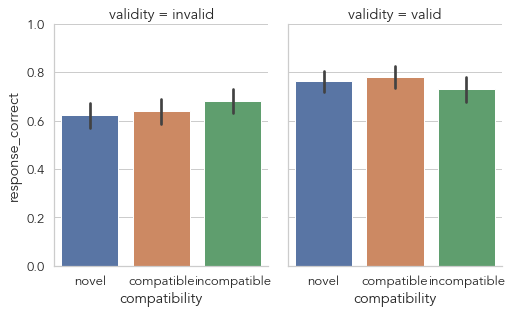

In [584]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
                col="validity",
#                 row="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

In [595]:
compatibility_order = ["novel","compatible","incompatible"]

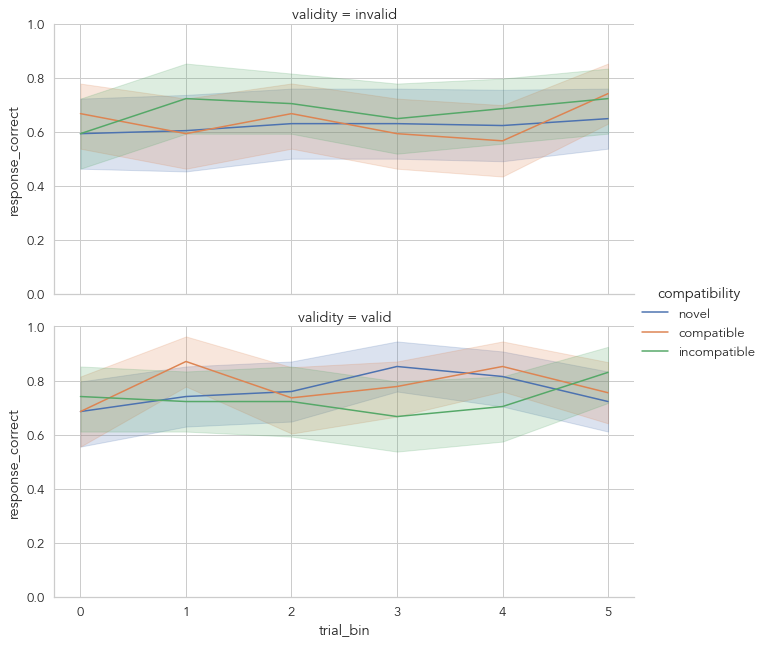

In [598]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="compatibility",
                hue_order = compatibility_order,
                row="validity",
                x="trial_bin",
#                 row="part_type",
                kind="line",
                height=4.6,
                aspect=2)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

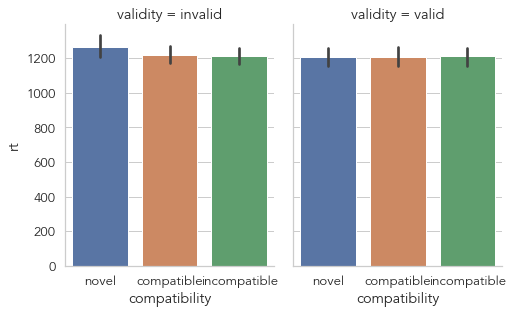

In [582]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="compatibility",
                col="validity",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
# plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

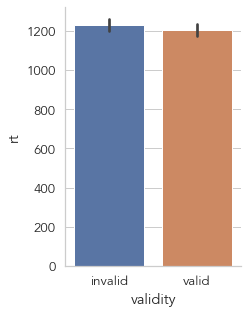

In [578]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="validity",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
# plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

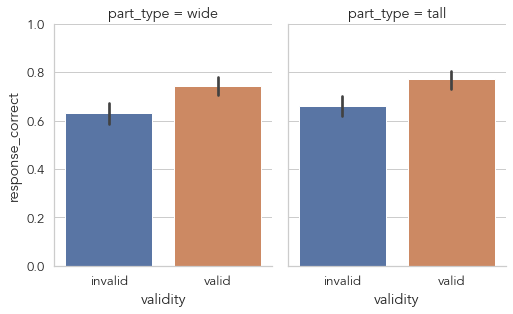

In [576]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="validity",
                col="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

## Wide vs Tall

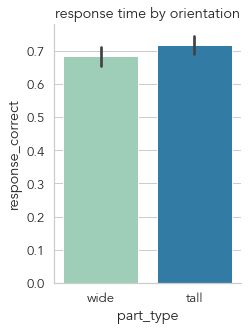

In [449]:
g = sns.catplot(data=df_zip,
                y="response_correct", 
                x="part_type",
                palette="YlGnBu",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by orientation')
plt.show()

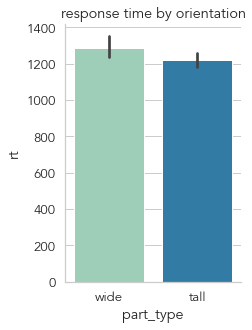

In [450]:
g = sns.catplot(data=df_zip,
                y="rt", 
                x="part_type",
#                 hue="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by orientation')
plt.show()

## Item

In [522]:
composite_order = np.sort(df_zip.composite_id.unique())

talls_101_114


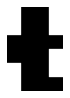

talls_102_122


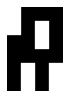

talls_111_127


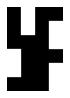

In [521]:
import requests

def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(1,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def toCompositeURL(stimID):
    stimURL = "https://zipping-composites-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_" + stimID + ".png"
    return(stimURL)

_ = [(print(stimID), show(toCompositeURL(stimID))) for stimID in composite_order]

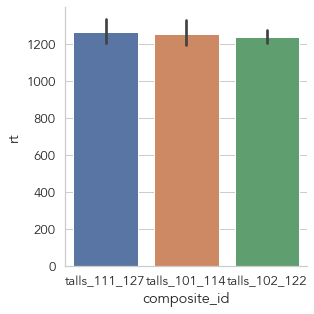

In [455]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="rt", 
                x="composite_id",
#                 hue="part_type",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

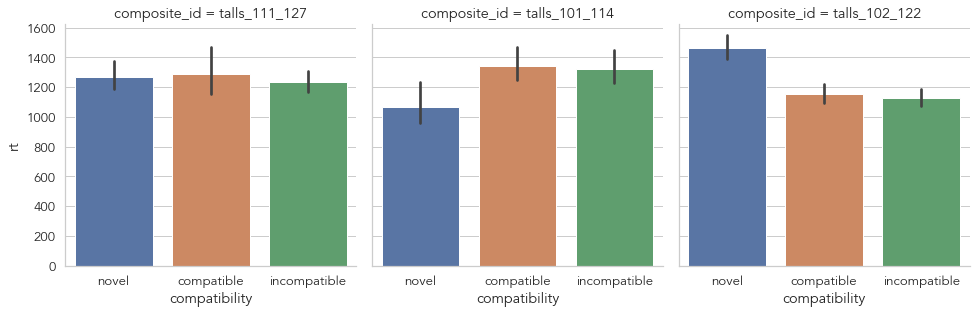

In [456]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="rt", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

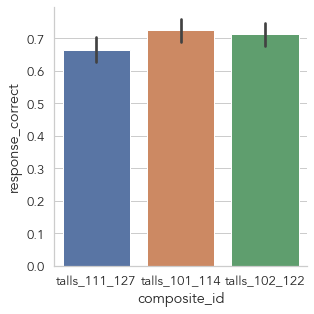

In [457]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="response_correct", 
                x="composite_id",
#                 hue="part_type",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

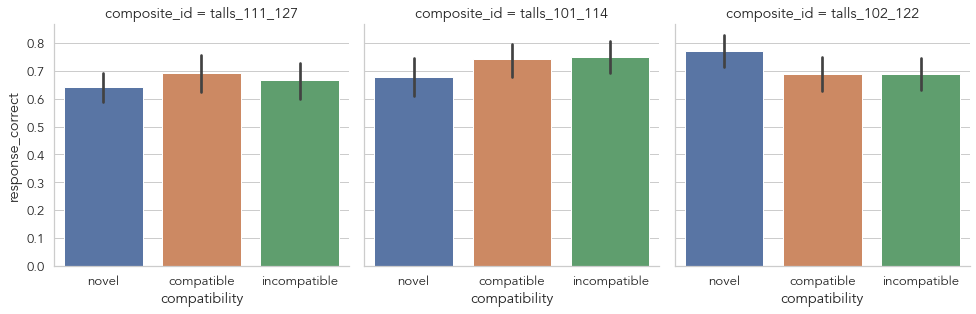

In [458]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="response_correct", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

### Item by wide and tall

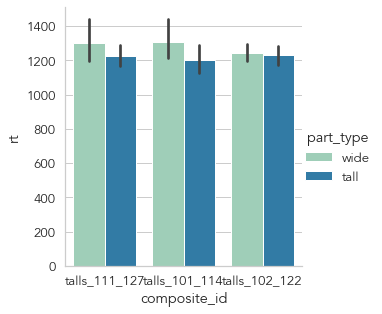

In [451]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="rt", 
                x="composite_id",
                hue="part_type",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

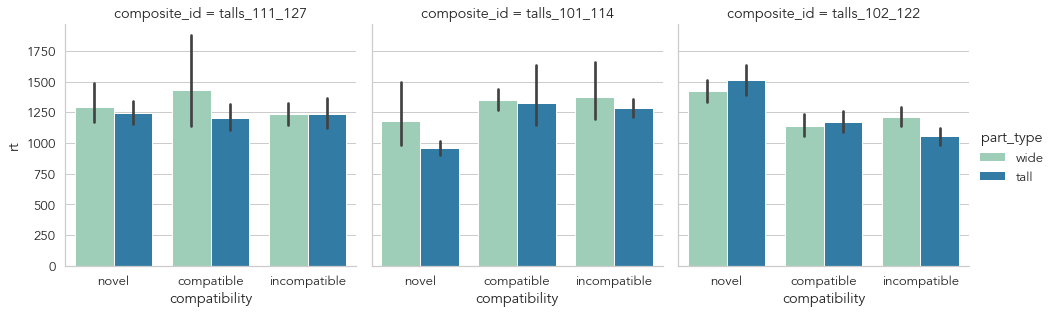

In [447]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="rt", 
                hue="part_type",
                x="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

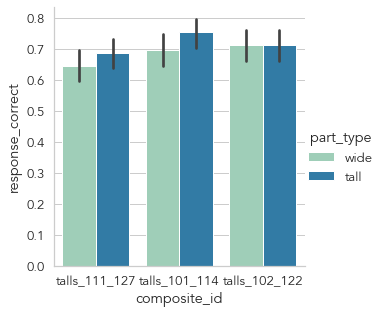

In [452]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="response_correct", 
                x="composite_id",
                hue="part_type",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

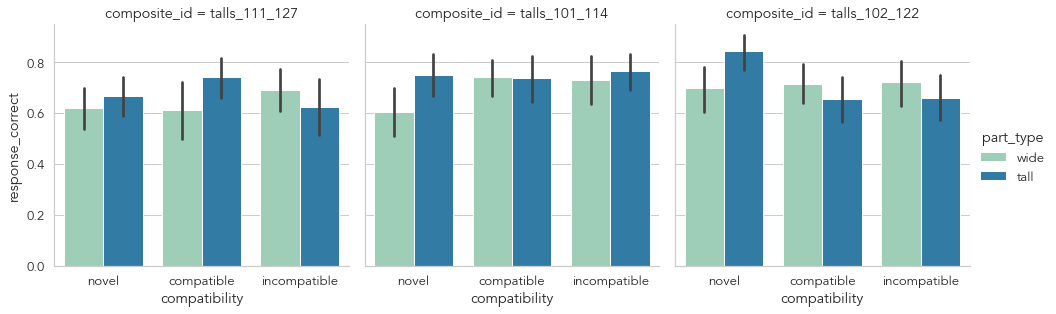

In [453]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="response_correct", 
                hue="part_type",
                x="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

In [505]:
df_zip_item_compatibility_mean = df_zip.groupby(['gameID','composite_id','compatibility']).mean().reset_index()\
                                    .query('compatibility in ["compatible","incompatible"]')

In [507]:
ppt_item_compatibility_diffs = df_zip_item_compatibility_mean.groupby(['gameID','composite_id'])\
    [['response_correct','rt','compatibility']]

In [512]:
ppt_item_compatibility_diffs_comp_incomp = ppt_item_compatibility_diffs.apply(compatibility_diff).reset_index()

<AxesSubplot:xlabel='composite_id', ylabel='diff_rt'>

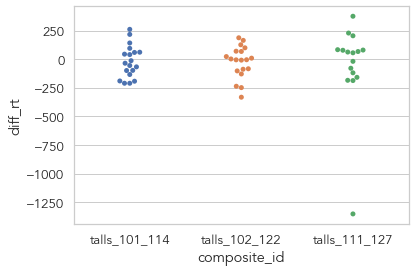

In [525]:
sns.swarmplot(data=ppt_item_compatibility_diffs_comp_incomp,
            y='diff_rt',
            x='composite_id',
            order=composite_order)

<AxesSubplot:xlabel='composite_id', ylabel='diff_response_correct'>

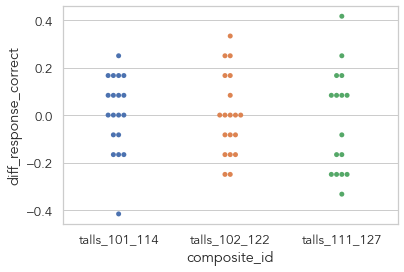

In [523]:
sns.swarmplot(data=ppt_item_compatibility_diffs_comp_incomp,
            y='diff_response_correct',
            x='composite_id',
            order=composite_order)

talls_101_114


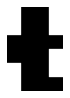

talls_102_122


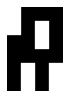

talls_111_127


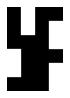

In [524]:
_ = [(print(stimID), show(toCompositeURL(stimID))) for stimID in composite_order]

## Block and condition

#### RT

Text(0.5, 1.0, 'response time by block and condition')

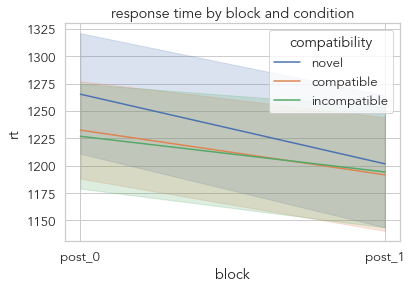

In [261]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
            )
plt.title('response time by block and condition')

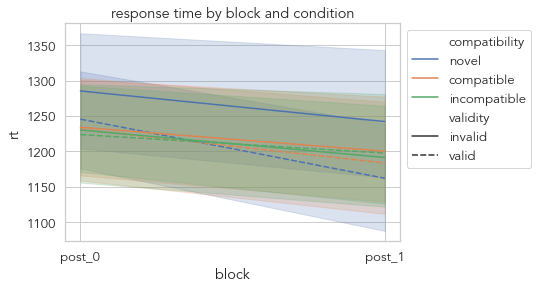

In [262]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                style="validity",
                hue="compatibility",
            )
plt.title('response time by block and condition')
plt.legend(bbox_to_anchor=(1,1))

The expectation was that rt would drop for compatible and (maybe) rise for incompatible.
But RT is higher for all conditions after the building task.
And even after practice they don't get as fast as they used to be.
What's going on?

What's the simplest explanation of this?
People get tired? But then they would continue to get worse.

People are taking longer to parse the objects?
But if so, they're doing it indiscriminantly- there is no difference between novel and built.

#### accuracy

Text(0.5, 1.0, 'accuracy time by block and condition')

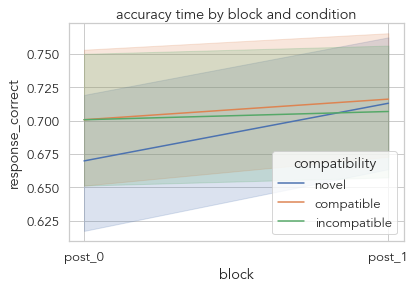

In [263]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="block",
                hue="compatibility",
            )
plt.title('accuracy time by block and condition')

But they're more accurate.

### Stimuli

Does the same pattern hold across different stimulus 'rotations'?

There are three stimuli that we rotate into different positions.
Each of the three stims can be novel. And the other two stims can have wide parts built or tall parts built.


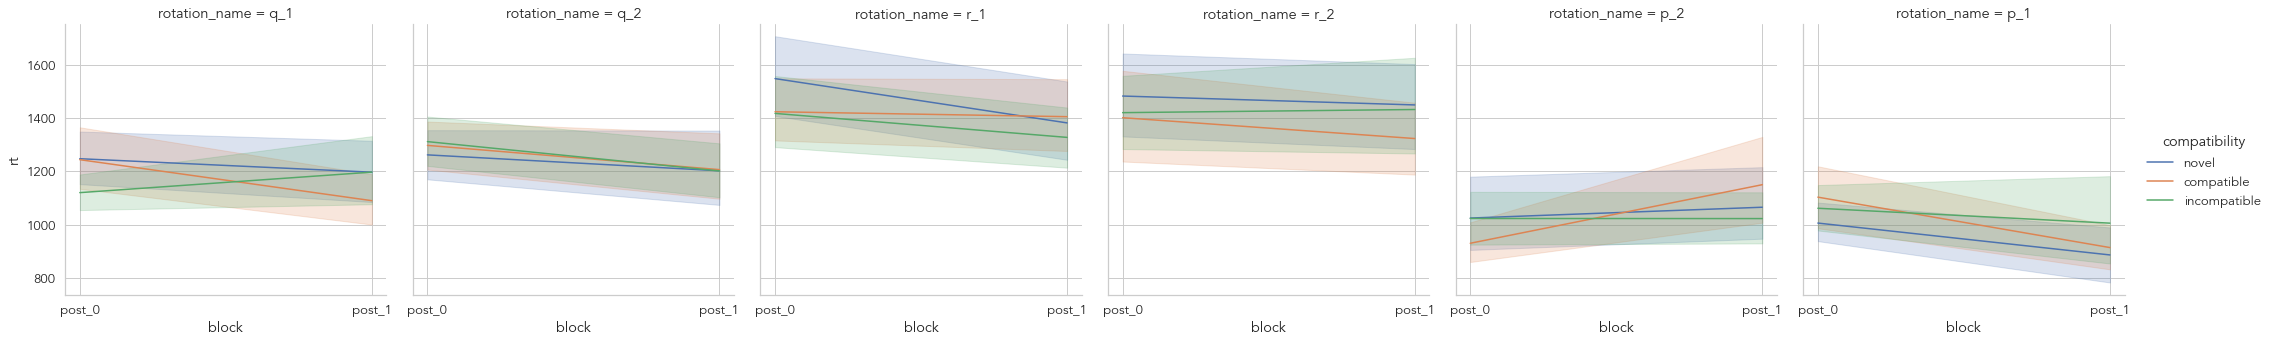

In [264]:
# response time by block and condition, separated by rotation 

f = sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="rt", 
                x="block",
                hue="compatibility",
                kind='line')

Text(0.5, 1.0, 'accuracy by block and condition')

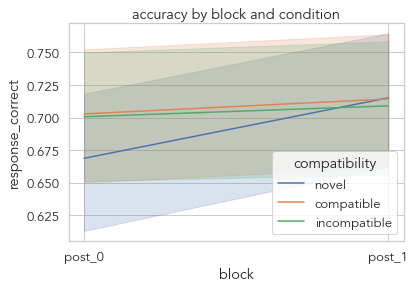

In [265]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
            )

plt.title('accuracy by block and condition')

Text(0.5, 1.0, 'accuracy by block and condition, separated by rotation')

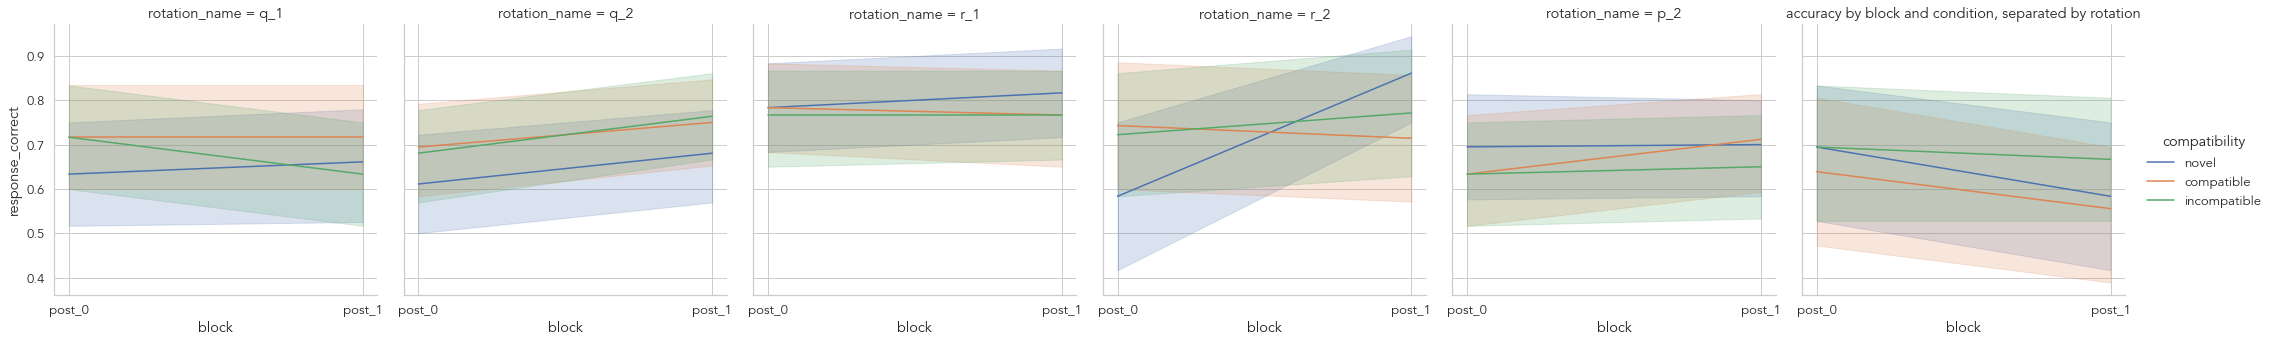

In [266]:
sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="response_correct", 
                x="block",
                hue="compatibility",
                kind='line')

plt.title('accuracy by block and condition, separated by rotation')

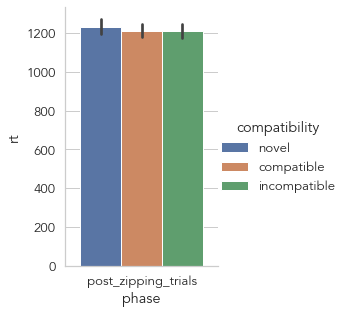

In [267]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()


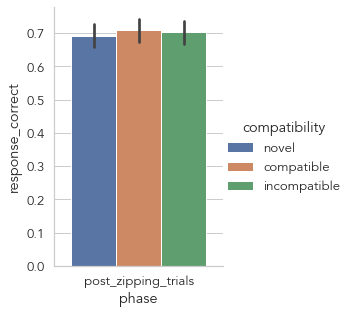

In [268]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## zipping trials- participant level performance

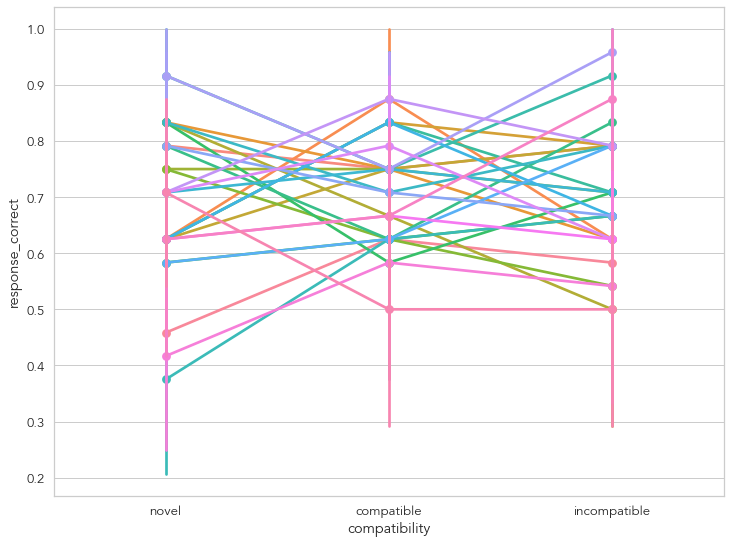

In [292]:
plt.figure(figsize=(12,9))

sns.pointplot(data = df_zip,
              y = 'response_correct',
              x = 'compatibility',
              hue = 'gameID')

plt.legend([],[], frameon=False)

In [301]:
df_zip['log_rt'] = np.log(df_zip.rt)

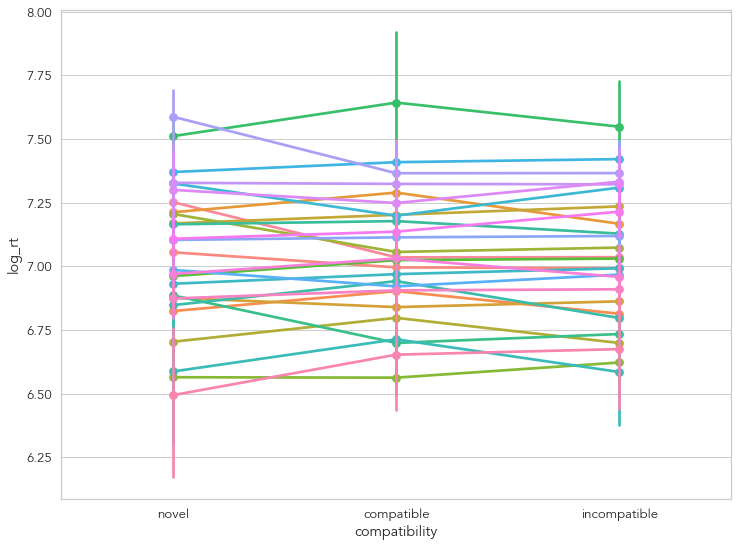

In [302]:
plt.figure(figsize=(12,9))

sns.pointplot(data = df_zip,
              y = 'log_rt',
              x = 'compatibility',
              hue = 'gameID')

plt.legend([],[], frameon=False)

Variation in participant performance

In [269]:
df_zip_ppt_mean = df_zip.groupby(['gameID']).mean().reset_index().merge(df_zip[['gameID','rotation_name']].groupby('gameID').last().reset_index(), 
                                                                        how='left',
                                                                        on='gameID')

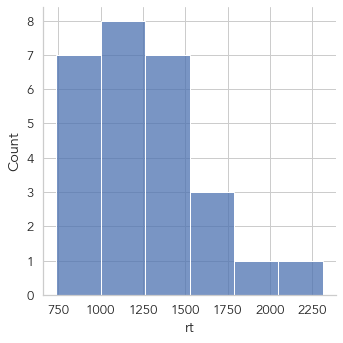

In [270]:
sns.displot(df_zip_ppt_mean, x='rt', kind='hist')

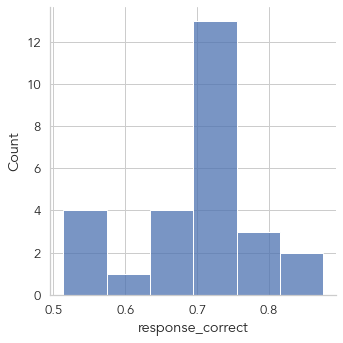

In [271]:
sns.displot(df_zip_ppt_mean, x='response_correct', kind='hist')

In [272]:
# anything that effects ppt level performance?

In [273]:
rotations = df_meta[['rotation', 'rotation_name']].groupby('rotation_name').first()
rotations = rotations.to_dict()

In [274]:
import requests

In [275]:
def show_stim(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def display_rotation(rotation_name, 
                     url_stem = 'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_{}.png'):
    print(rotation_name)
    print('build_wide      build_tall      novel')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_wide']), ax1)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_tall']), ax2)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['novel']), ax3)


def show_part(part_id,
              verbose = False,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    if verbose:
        print(part_id)
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(3,2))
    plt.imshow(img)
    plt.axis('off')
    
def show_part_subplot(part_id,
                      ax,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(part_id)


In [276]:
rotation_order = np.sort(df_zip_ppt_mean.rotation_name.unique())

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

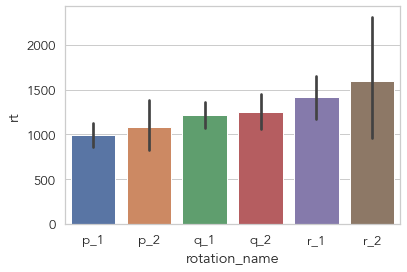

In [277]:
sns.barplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

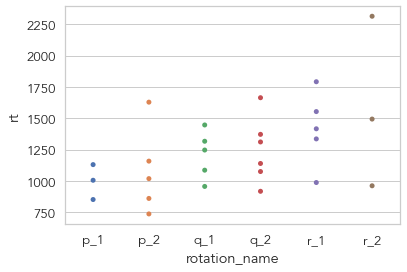

In [278]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

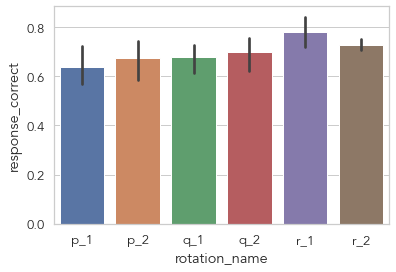

In [279]:
sns.barplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

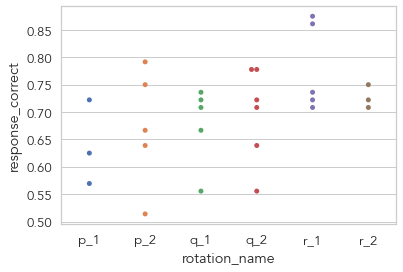

In [280]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

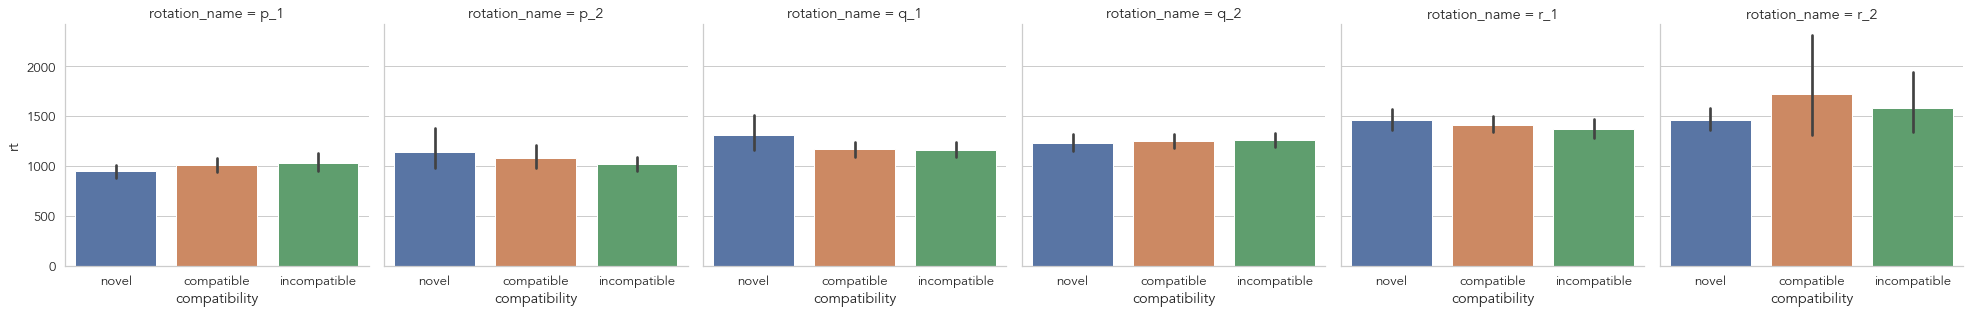

In [464]:
g = sns.catplot(data=df_zip,
                col="rotation_name",
                col_order=rotation_order,
                y="rt", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

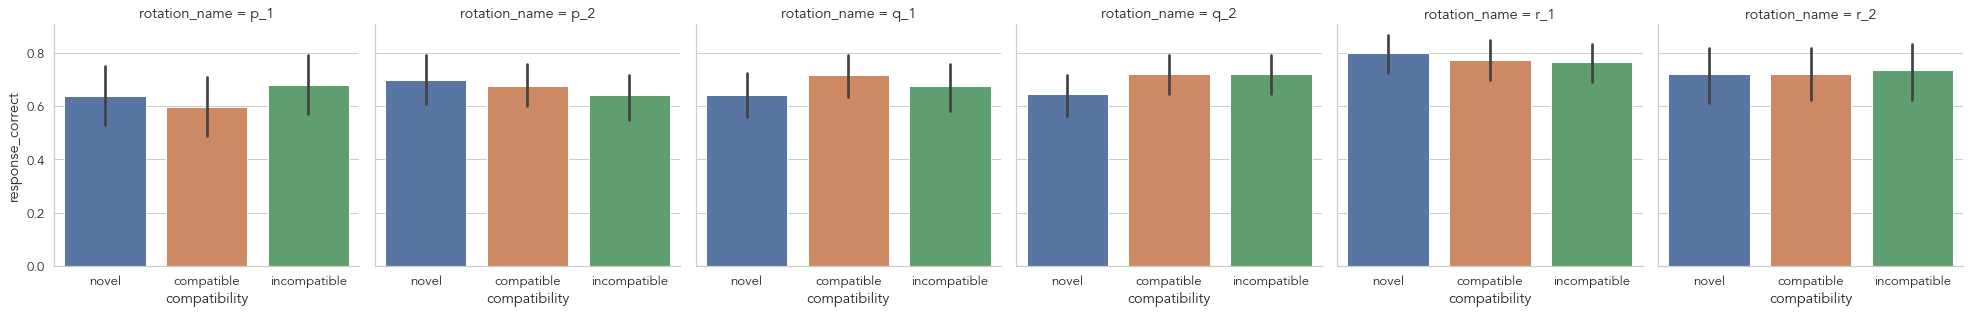

In [465]:
g = sns.catplot(data=df_zip,
                col="rotation_name",
                col_order=rotation_order,
                y="response_correct", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

p_1
build_wide      build_tall      novel


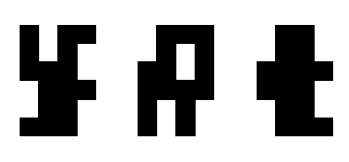

In [281]:
display_rotation(rotation_order[0])

p_2
build_wide      build_tall      novel


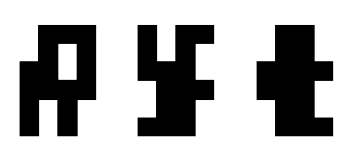

In [282]:
display_rotation(rotation_order[1])

q_1
build_wide      build_tall      novel


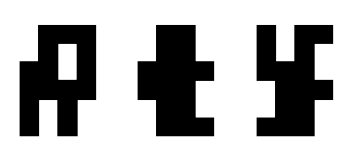

In [283]:
display_rotation(rotation_order[2])

q_2
build_wide      build_tall      novel


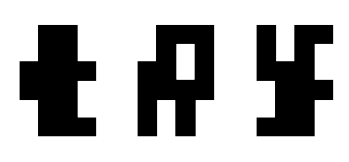

In [284]:
display_rotation(rotation_order[3])

r_1
build_wide      build_tall      novel


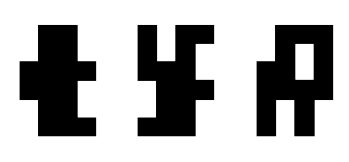

In [285]:
display_rotation(rotation_order[4])

r_2
build_wide      build_tall      novel


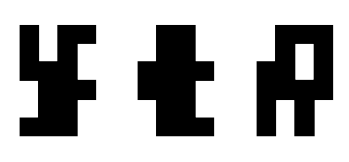

In [286]:
display_rotation(rotation_order[5])

<AxesSubplot:xlabel='rt', ylabel='response_correct'>

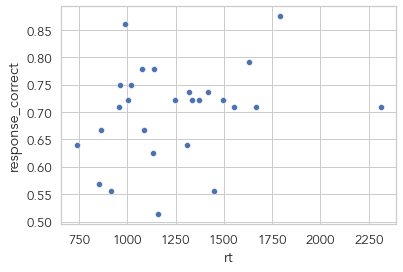

In [287]:
# looking for speed accuracy trade-off

sns.scatterplot(data = df_zip_ppt_mean,
                x = 'rt',
                y = 'response_correct')

# Within PPT differences

Between compatible and incompatible

In [335]:
df_zip_compatibility_mean = df_zip.groupby(['gameID','compatibility']).mean().reset_index()

In [336]:
ppt_compatibility_diffs = df_zip_compatibility_mean.groupby(['gameID'])[['response_correct','rt','compatibility']]

In [337]:
ppt_compatibility_diffs_comp_incomp = ppt_compatibility_diffs.apply(compatibility_diff)

In [338]:
ppt_compatibility_diffs_nov_comp = \
    ppt_compatibility_diffs.apply(compatibility_diff, compatibilities=['novel','incompatible'])

Text(0.5, 1.0, 'difference between compatible and incompatible')

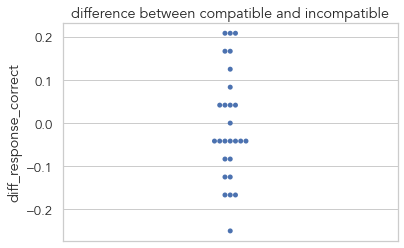

In [359]:
sns.swarmplot(data = ppt_compatibility_diffs_comp_incomp,
            y = 'diff_response_correct')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

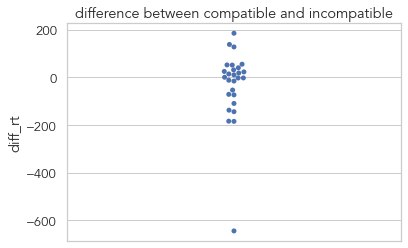

In [360]:
sns.swarmplot(data = ppt_compatibility_diffs_comp_incomp,
            y = 'diff_rt')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

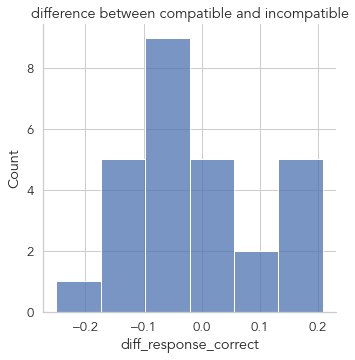

In [353]:
sns.displot(data = ppt_compatibility_diffs_comp_incomp,
            x = 'diff_response_correct')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

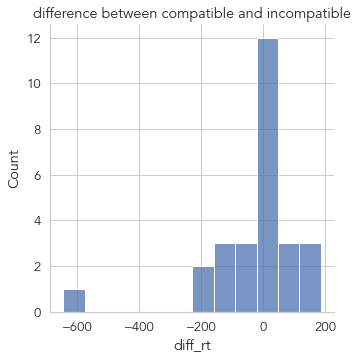

In [354]:
sns.displot(data = ppt_compatibility_diffs_comp_incomp,
            x = 'diff_rt')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

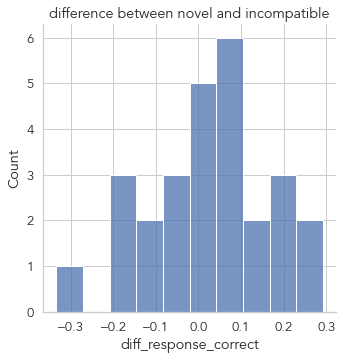

In [355]:
sns.displot(data = ppt_compatibility_diffs_nov_comp,
            x = 'diff_response_correct',
            bins=10)

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

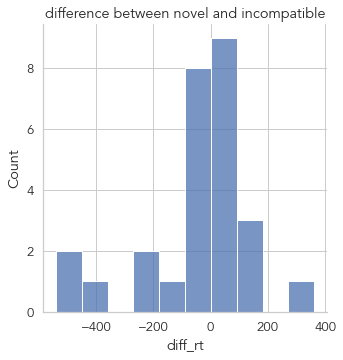

In [356]:
sns.displot(data = ppt_compatibility_diffs_nov_comp,
            x = 'diff_rt',
            bins=10)

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

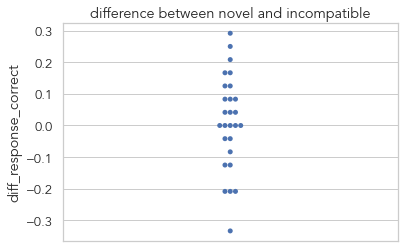

In [361]:
sns.swarmplot(data = ppt_compatibility_diffs_nov_comp,
            y = 'diff_response_correct')

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

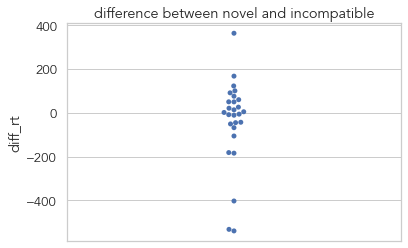

In [362]:
sns.swarmplot(data = ppt_compatibility_diffs_nov_comp,
            y = 'diff_rt')

plt.title('difference between novel and incompatible')

## Differences between conditions by mean task performance

In [412]:
df_zip_diffs_nov_comp = ppt_compatibility_diffs_nov_comp.merge(df_zip_ppt_mean, on='gameID')
df_zip_diffs_comp_incomp = ppt_compatibility_diffs_comp_incomp.merge(df_zip_ppt_mean, on='gameID')

In [416]:
df_zip_diffs_comp_incomp

,gameID,diff_response_correct,diff_rt,index,trial_start_time,trial_finish_time,rt,response_correct,practice,composite_duration,gap_duration,chunk_duration,stimVersionInd,key_presses,trial_index,time_elapsed,trial_num,flagRT,recalculated_response_correct,rotation_name
0,0581-6a290675-ac2d-4446-a181-3d3e545c534e,-0.041667,128.412500,2329.888889,1.660176e+12,1.660176e+12,1311.555556,0.638889,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,7.195063e+05,35.5,0.000000,0.638889,q_2
1,1199-27a29656-1dbe-4aeb-9305-8dbd12e55839,-0.166667,138.920833,2197.236111,1.660176e+12,1.660176e+12,1553.652778,0.708333,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,1.012029e+06,35.5,0.000000,0.708333,r_1
2,1711-d5c126e7-318a-4ebd-bccf-e865f5c0e2e1,-0.041667,25.312500,917.541667,1.658775e+12,1.658775e+12,962.265278,0.750000,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,9.705923e+05,35.5,0.000000,0.750000,r_2
3,1945-8f8714ae-b89b-4ca0-b013-3373fc5763da,0.208333,10.770833,2621.375000,1.660177e+12,1.660177e+12,1006.277778,0.722222,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,8.877524e+05,35.5,0.000000,0.722222,p_1
4,2002-0d32a6aa-c1d1-4585-aee2-b0e79561065d,0.083333,18.629167,2125.875000,1.660176e+12,1.660176e+12,1075.838889,0.777778,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,2.601491e+06,35.5,0.000000,0.777778,q_2
5,2180-6e340123-d0e2-47e1-a832-4a0c061db44b,0.041667,40.770833,1379.930556,1.660174e+12,1.660174e+12,1130.972222,0.625000,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,9.811090e+05,35.5,0.000000,0.625000,p_1
6,2251-16ae277d-65bc-4fcc-85d2-5976fc60fdd6,-0.250000,-71.041667,821.180556,1.658775e+12,1.658775e+12,957.104167,0.708333,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,7.375185e+05,35.5,0.000000,0.708333,q_1
7,2497-d16fe438-1b10-4726-b497-72abb758767b,-0.166667,-73.345833,1067.625000,1.658775e+12,1.658775e+12,861.451389,0.666667,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,1.256525e+06,35.5,0.000000,0.666667,p_2
8,2712-3ef02430-77ed-4234-9278-5b5afb277889,0.041667,52.695833,1023.736111,1.658775e+12,1.658775e+12,1372.100000,0.722222,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,1.148303e+06,35.5,0.000000,0.722222,q_2
9,2722-e9ac1150-6375-4d66-be29-19cec364601f,0.166667,55.733333,1939.930556,1.660176e+12,1.660176e+12,1086.694444,0.666667,0.0,600.0,400.0,1000.0,1.0,0.000000,64.0,7.379469e+05,35.5,0.000000,0.666667,q_1


### Novel to incompatible

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

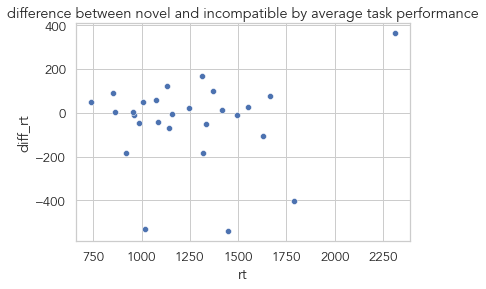

In [420]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'rt',
                y = 'diff_rt')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

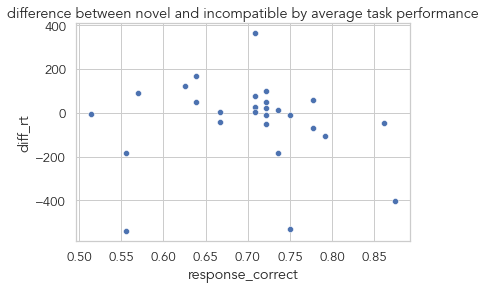

In [421]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'response_correct',
                y = 'diff_rt')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

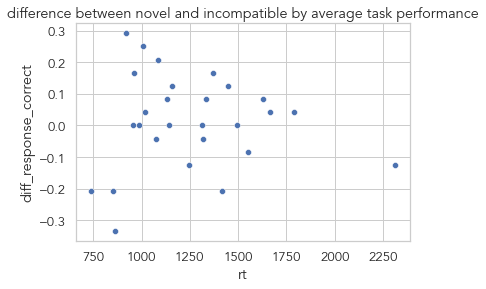

In [423]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'rt',
                y = 'diff_response_correct')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

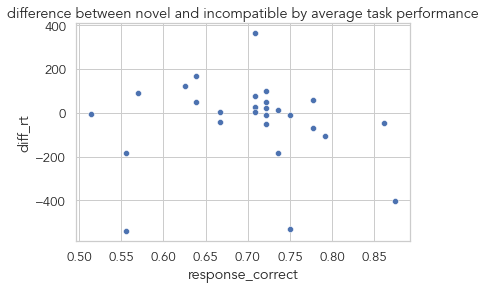

In [418]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'response_correct',
                y = 'diff_response_correct')

plt.title('difference between novel and incompatible by average task performance')

### compatible to incompatible

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

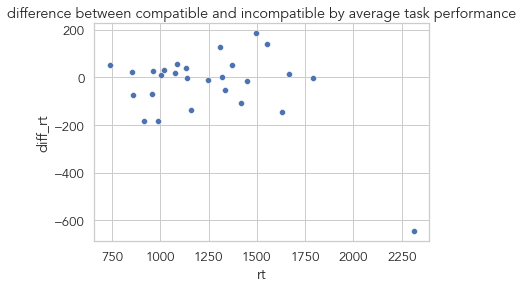

In [424]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rt',
                y = 'diff_rt')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

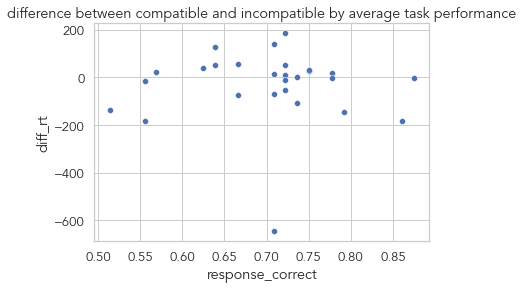

In [425]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'response_correct',
                y = 'diff_rt')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

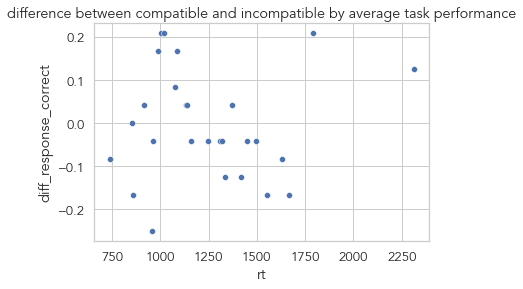

In [426]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rt',
                y = 'diff_response_correct')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

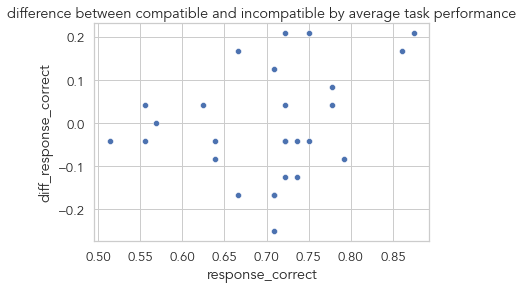

In [427]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'response_correct',
                y = 'diff_response_correct')

plt.title('difference between compatible and incompatible by average task performance')

### Differences in conditions by rotation

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

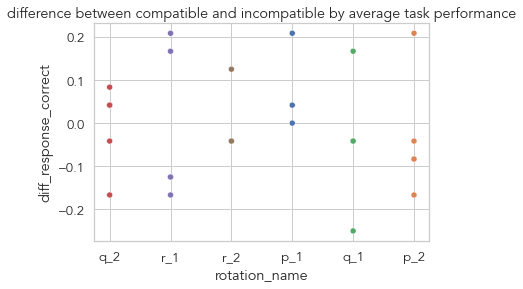

In [571]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rotation_name',
                y = 'diff_response_correct',
                hue = 'rotation_name',
                hue_order = rotation_order,
                legend=False)

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

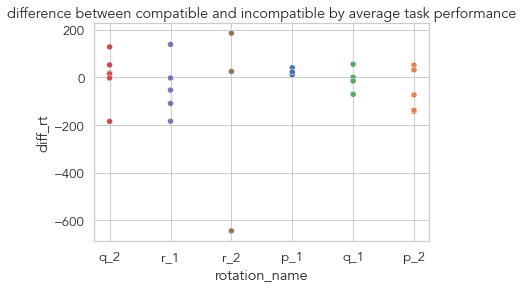

In [572]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rotation_name',
                y = 'diff_rt',
                hue = 'rotation_name',
                hue_order = rotation_order,
                legend=False)

plt.title('difference between compatible and incompatible by average task performance')

### Part type

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='response_correct', ylabel='Density'>

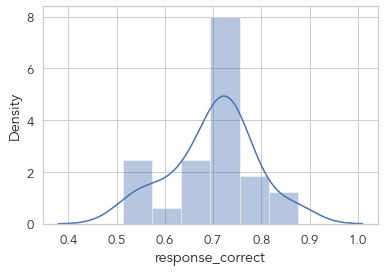

In [601]:
sns.distplot(df_zip_ppt_mean.response_correct)

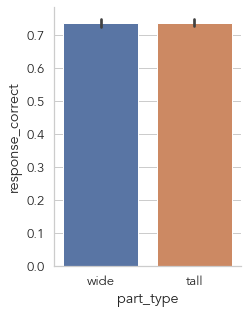

In [51]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="part_type",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

### Stimulus

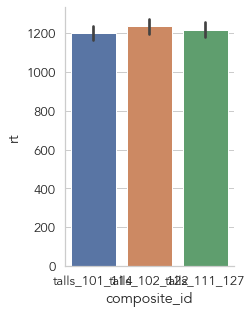

In [604]:
# Is one of the stims easier across the board?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="composite_id",
#                 hue="part_type",
                order=composite_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

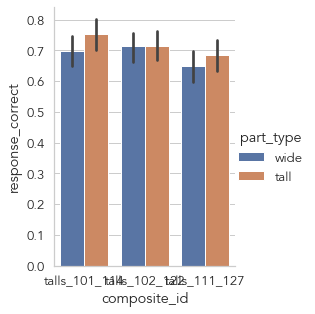

In [607]:
# Are any of the stims easier in one direction?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_id",
                order=composite_order,
                hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## d'

In [611]:
from scipy.stats import norm

Z = norm.ppf

In [612]:
def d_primes(df):
    
    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_hit = 0.5 / len(yes_trials)
    if H == 1: 
#         H = 1 - half_hit
        H = 0.9999
    if H == 0: 
#         H = half_hit
        H = 0.0001
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']
    
    F = len(no_trials[no_trials.response!=df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_fa = 0.5 / len(no_trials)
    if F == 1: 
#         F = 1 - half_fa
        F = 0.9999
    if F == 0: 
#         F = half_fa
        F = 0.0001
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [613]:
d_blocks = df_zip[~df_zip.flagRT].groupby(['gameID','block']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block', ylabel='d_prime'>

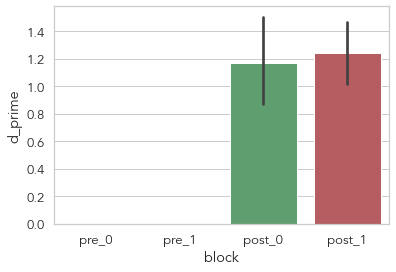

In [614]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block',
            order=block_order)

In [615]:
d_phase = df_zip[~df_zip.flagRT].groupby(['gameID','phase']).apply(d_primes).reset_index()
d_phase = d_phase.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='phase', ylabel='d_prime'>

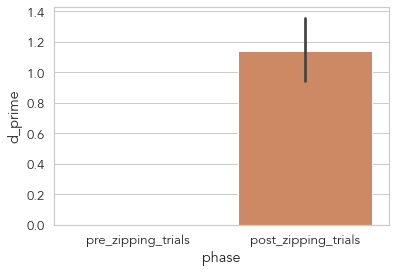

In [616]:
sns.barplot(data = d_phase,
            y = 'd_prime',
            x = 'phase',
            order = phase_order)

In [617]:
d_phase_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','phase','compatibility']).apply(d_primes).reset_index()
d_phase_compatibility = d_phase_compatibility.rename(columns = {0: 'd_prime'})

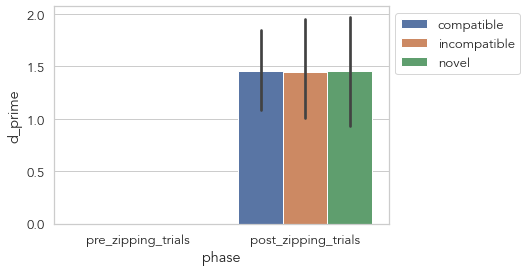

In [623]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            x = 'phase',
            hue = 'compatibility',
            order = phase_order)
plt.legend(bbox_to_anchor=(1,1))

<AxesSubplot:xlabel='compatibility', ylabel='d_prime'>

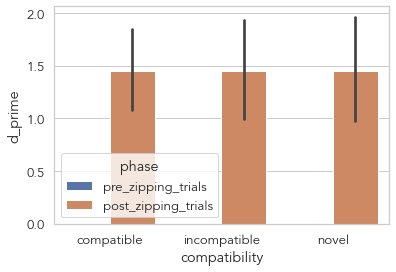

In [619]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            hue = 'phase',
            x = 'compatibility',
            hue_order = phase_order)

In [620]:
d_block_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','block','compatibility']).apply(d_primes).reset_index()
d_block_compatibility = d_block_compatibility.rename(columns = {0: 'd_prime'})

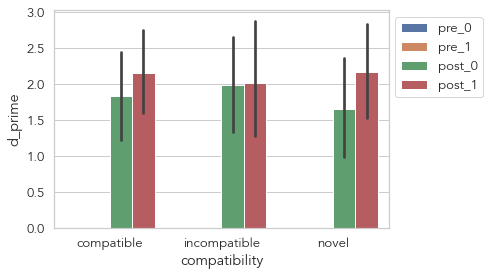

In [621]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            hue = 'block',
            x = 'compatibility',
            hue_order = block_order)
plt.legend(bbox_to_anchor=(1,1))

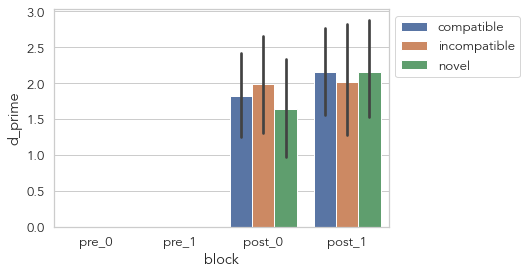

In [622]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            x = 'block',
            hue = 'compatibility',
            order = block_order)
plt.legend(bbox_to_anchor=(1,1))

## Building Trials

In [375]:
df_build['trial_duration'] = df_build.timeAbsolute - df_build.trial_start_time
df_build['trial_duration_min'] =  df_build['trial_duration'] / (60 * 1000)

### whole trials

In [376]:
ppts_left = list(df_zip.gameID.unique())

In [377]:
df_build = df_build[df_build.gameID.isin(ppts_left)]

In [378]:
df_ppt_info = df_zip[['gameID', 'rotation_name']].groupby('gameID').first()

In [379]:
df_build_means = df_build.groupby('gameID').mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_phase_means = df_build.groupby(['gameID','rep']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_part_means = df_build.groupby(['gameID','chunk_id']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')

In [380]:
df_build_phase_means

,gameID,rep,timeAbsolute,timeRelative,trial_start_time,relative_time,n_resets,trial_index,time_elapsed,trial_num,trial_duration,trial_duration_min,rotation_name
0,0581-6a290675-ac2d-4446-a181-3d3e545c534e,0,1.660175e+12,71372.25,1.660175e+12,16162.00,0.25,4.5,66886.25,1.5,16161.75,0.269363,q_2
1,0581-6a290675-ac2d-4446-a181-3d3e545c534e,1,1.660176e+12,142439.25,1.660176e+12,15106.50,0.25,8.5,138007.00,5.5,15106.25,0.251771,q_2
2,0581-6a290675-ac2d-4446-a181-3d3e545c534e,2,1.660176e+12,212196.75,1.660176e+12,13441.00,0.00,12.5,207840.50,9.5,13441.00,0.224017,q_2
3,0581-6a290675-ac2d-4446-a181-3d3e545c534e,3,1.660176e+12,278197.00,1.660176e+12,14364.25,0.00,16.5,273834.00,13.5,14364.00,0.239400,q_2
4,1199-27a29656-1dbe-4aeb-9305-8dbd12e55839,0,1.660175e+12,182851.75,1.660175e+12,16134.50,0.00,4.5,183518.50,1.5,16134.25,0.268904,r_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,9165-a89fbce3-5cb1-4b1e-8ef8-b546d032ad92,3,1.660174e+12,273196.00,1.660174e+12,8886.75,0.00,16.5,273772.25,13.5,8886.50,0.148108,p_2
104,9839-2624e9ad-e118-4082-95a1-7254dd7e29ec,0,1.660174e+12,190427.00,1.660173e+12,34682.00,0.25,4.5,190593.75,1.5,34681.75,0.578029,p_2
105,9839-2624e9ad-e118-4082-95a1-7254dd7e29ec,1,1.660174e+12,293171.50,1.660174e+12,56373.25,0.50,8.5,293433.25,5.5,56372.75,0.939546,p_2
106,9839-2624e9ad-e118-4082-95a1-7254dd7e29ec,2,1.660174e+12,478933.00,1.660174e+12,10865.00,0.00,12.5,479252.50,9.5,10864.50,0.181075,p_2


### Resets

In [381]:
# what is the overall variation in build performance?

Text(0.5, 1.0, 'mean number of resets across trials')

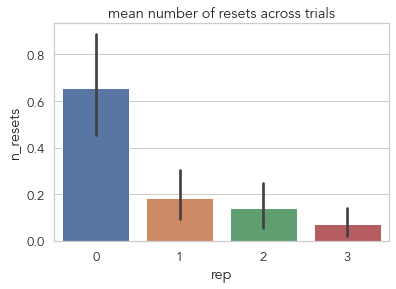

In [382]:
sns.barplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep')
plt.title('mean number of resets across trials')

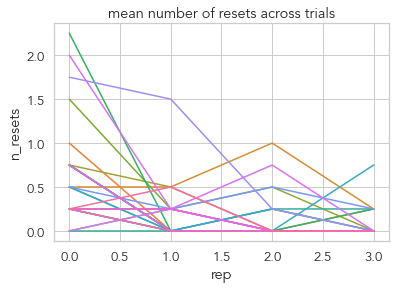

In [383]:
sns.lineplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep',
            hue= 'gameID')
plt.title('mean number of resets across trials')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean number of resets in trial for each ppt')

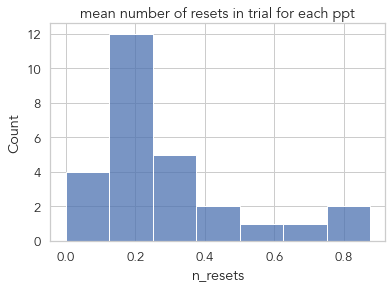

In [384]:
sns.histplot(df_build_means.n_resets)
plt.title('mean number of resets in trial for each ppt')

### Build time

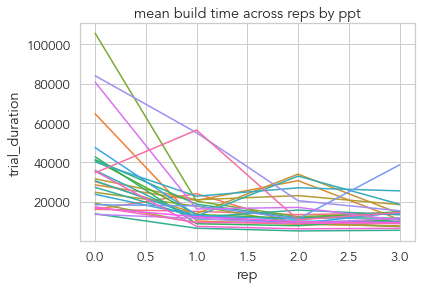

In [385]:
sns.lineplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep',
            hue= 'gameID')
plt.title('mean build time across reps by ppt')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean build time across reps')

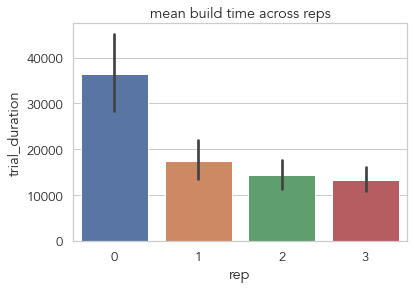

In [386]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep')

plt.title('mean build time across reps')

Text(0.5, 1.0, 'mean ppt build time')

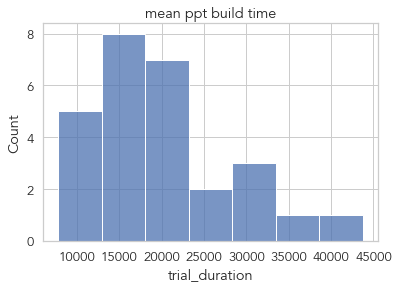

In [387]:
# what's the variation across people?

sns.histplot(data = df_build_means,
            x = 'trial_duration')

plt.title('mean ppt build time')

### What explains this variation?

#### Are some chunks harder than others?

In [388]:
three_composites = pd.read_csv('../../stimuli/block_utils/ambiguous/df_stims_pre_post_run_0.csv')

In [389]:
three_composites[['tower_id_tall','tower_A_tall_id','tower_B_tall_id','tower_A_wide_id','tower_B_wide_id']]

,tower_id_tall,tower_A_tall_id,tower_B_tall_id,tower_A_wide_id,tower_B_wide_id
0,talls_111_127,tall_111,tall_127,wide_011,wide_015
1,talls_102_122,tall_102,tall_122,wide_025,wide_010
2,talls_101_114,tall_101,tall_114,wide_019,wide_008


In [396]:
# ordered first by tall/ wide, then by composite in which they appear
part_order_tall_wide = \
              ['tall_111', 'tall_127',
              'tall_102', 'tall_122',
              'tall_101', 'tall_114',
              'wide_011', 'wide_015',
              'wide_025', 'wide_010',
              'wide_019', 'wide_008']

# ordered first by composite in which they appear, then by tall/ wide
part_order_composites = \
              ['tall_111', 'tall_127',
               'wide_011', 'wide_015',
               'tall_102', 'tall_122',
               'wide_025', 'wide_010',
               'tall_101', 'tall_114',
               'wide_019', 'wide_008']

part_order = part_order_composites

Text(0.5, 1.0, 'mean number of resets across parts')

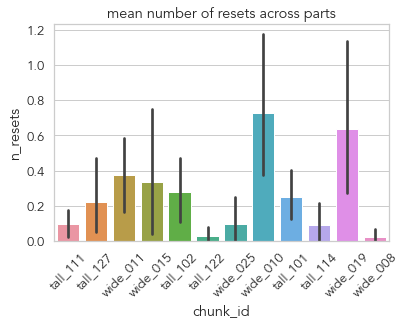

In [397]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'n_resets',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean number of resets across parts')

Text(0.5, 1.0, 'mean build time across parts')

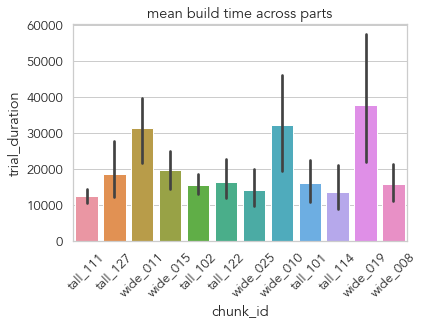

In [398]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'trial_duration',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean build time across parts')

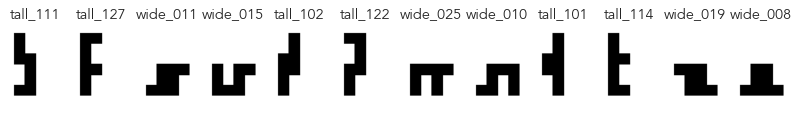

In [399]:
fig, axs = plt.subplots(1, 12, figsize=(14,5))

for i, part in enumerate(part_order):
    show_part_subplot(part, axs[i])

#### Rotation

Text(0.5, 1.0, 'mean build time across rotations')

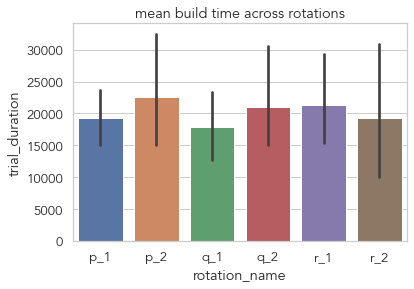

In [400]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rotation_name',
            order=rotation_order)

plt.title('mean build time across rotations')

In [401]:
df_meta[['rotation_name','rotation']].iloc[3]['rotation']

{'build_wide': 'talls_111_127',
 'build_tall': 'talls_101_114',
 'novel': 'talls_102_122'}

### How does building performance relate to zipping performance?

Do the better builders have larger pre-post differences? (specifically for compatible trials?)
Do the worse builders have larger pre-post differences? (specifically for compatible trials?)
Do the most improving builders have larger pre-post differences? (specifically for compatible trials?)

In [402]:
df_build_means_condensed = df_build_means[['gameID', 'trial_duration', 'n_resets']].rename(columns = {'trial_duration':'build_duration'})

In [403]:
# need a dataframe with mean building performance and diffs.
df_build_zip_performance =  ppt_phase_compatibility_diffs.merge(df_build_means_condensed)

NameError: name 'ppt_phase_compatibility_diffs' is not defined

In [ ]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_response_correct',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.legend(bbox_to_anchor=(1,1))


In [ ]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_rt',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.ylim(-2000,2500)
plt.legend(bbox_to_anchor=(1,1))

In [ ]:
sns.relplot(data = df_build_zip_performance,
                col = 'compatibility',
                y = 'diff_response_correct',
                x = 'build_duration')

### individual block placements

In [ ]:
df_block_placements

### resets

In [60]:
df_resets.columns

Index(['_id', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'studyLocation', 'n_blocks_when_reset', 'trial_start_time',
       'relative_time', 'datatype', 'stimURL', 'stimulus', 'stimId',
       'chunk_id', 'rep', 'condition', 'chunk_type', 'n_block', 'n_resets'],
      dtype='object')

In [61]:
import blockworld_utils as utils

In [62]:
# [utils.draw_world(utils.worldify(w)) for w in df_block_placements.blocks]

In [99]:
df_survey

NameError: name 'df_survey' is not defined

In [64]:
df_zip.to_csv('../results/zipping/csv/pilot_0_zipping_trials.csv')

In [65]:
!! open .

[]